# **Flood Extent Mapping and Building Segmentation Model Process**

Note: Aspects of the code are adapted by Gemini (2025), the rest is adapted from in-class material and labs.

In [ ]:
# Set up routine
!pip install geemap --quiet

import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import ee

ee.Authenticate()
ee.Initialize(project='geog-761-467309')

In [ ]:
# Control variables
AOI = ee.Geometry.BBox(173.20,-41.35, 173.35, -41.25)
START_DATE = '2022-08-01'
END_DATE = '2022-08-28'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

# 1. Process Sentinel-2

In [ ]:
# Building the SAR-2 image
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

# Apply the function in order to generate the collection
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

In [ ]:
# Add the s2cloudless probability layer and derived cloud mask as bands to an S2 SR image input.
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

# Add bands that add dark pixels, cloud projection and shadows
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

# Assemble all of the cloud and cloud shadow components and produce a final mask
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

In [ ]:
# Define a function to apply the cloud mask to the S2 spectral bands
def apply_cld_shdw_mask(img):
    cloudmask = img.select('cloudmask')
    SPECTRAL_BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    masked_spectral = img.select(SPECTRAL_BANDS).updateMask(cloudmask.Not())
    aux_bands = img.select(['cloudmask', 'probability'])
    return masked_spectral.addBands(aux_bands)

# Process the collection
s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())

# Display the cloud free composite
def display_cloud_free_mosaic(s2_sr_median, AOI):
    # Create a geemap Map object and center it on the AOI
    m = geemap.Map()
    m.centerObject(AOI, 12)

    # Add the Sentinel-2 RGB mosaic
    m.addLayer(
        s2_sr_median,
        {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
        'S2 cloud-free mosaic')

    return m

display_map = display_cloud_free_mosaic(s2_sr_median, AOI)

# 2. Process sentinel 1

In [ ]:
# Get the Sentinel-1 SAR image collection
s1 = ee.ImageCollection('COPERNICUS/S1_GRD')

# Filter the collection by your defined area and date, and specific parameters for flood mapping
s1_filtered = s1.filterBounds(AOI) \
               .filterDate(START_DATE, END_DATE) \
               .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
               .filter(ee.Filter.eq('instrumentMode', 'IW')) \
               .select('VV')


# # Take a single image (e.g., median) of the filtered collection
s1_image = s1_filtered.median()

# Display the SAR image on a map to visually inspect the data
def display_s1_image(image, aoi):
    """
    Displays the Sentinel-1 image on a map.
    """
    m = geemap.Map()
    m.centerObject(aoi, 15)

    # Define a custom color palette for a clearer visualization of water and land
    vis_params = {'min': -20, 'max': 0}

    m.addLayer(image, vis_params, 'Sentinel-1 VV')

    return m

display_map = display_s1_image(s1_image, AOI)

# 3. Data fusion

In [ ]:
# Define visualisation parameters
s2_vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
s1_vis_params = {'min': -20, 'max': 0, 'palette': ['black', 'white']}

# Create the map
Map = geemap.Map()
Map.centerObject(AOI, 12)

# Add both layers
Map.addLayer(s2_sr_median, s2_vis_params, 'Sentinel-2 (Optical)')
Map.addLayer(s1_image, s1_vis_params, 'Sentinel-1 (Radar)')

Map.addLayerControl()

In [ ]:
# Reproject and resample the Sentinel-1 image to match Sentinel-2
# We use the projection of a Sentinel-2 band as the target
s1_reprojected = s1_image.reproject(
    crs=s2_sr_median.select('B4').projection(),
    scale=10
)

# Rename the Sentinel-1 band for clarity after stacking
s1_reprojected = s1_reprojected.rename('VV_band')

# Fuse the images by adding the Sentinel-1 band to the Sentinel-2 image
# The result is a single image with all the spectral bands from S2 and the VV band from S1
fused_image = s2_sr_median.addBands(s1_reprojected)

# Print the band names to confirm the fusion was successful
print("Band names of the fused image:", fused_image.bandNames().getInfo())

# You can now display the fused image or use it for your machine learning models
# For a visual check, you can display a combination of S2 RGB and S1 VV
m = geemap.Map()
m.centerObject(AOI, 15)

# Display the fused image with a combination of S2 and S1 data for visualization
# For example, let's use a combination of B4, B3, and the S1 VV band
vis_params_fused = {
    'bands': ['B4', 'B3', 'B2'],
    'min': [0, 0, 0],
    'max': [2500, 2500, 2500],
    'gamma': [1.1, 1.1, 1.1]
}

m.addLayer(fused_image.select(['B4', 'B3', 'B2']), vis_params_fused, 'Fused S2 Image (RGB)')
m

Band names of the fused image: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'cloudmask', 'probability', 'VV_band']


Map(center=[-41.299995336505745, 173.27500000000165], controls=(WidgetControl(options=['position', 'transparen…

# 4. Landcover classification model

In [ ]:
# Define area of interest
aoi = ee.Geometry.Rectangle([173.20,-41.35, 173.35, -41.25])
Map.addLayer(aoi, {}, 'AOI')

In [ ]:
classification_image = fused_image.clip(aoi)

# Set up the visualisation:
Map = geemap.Map(center=[-41.285, 173.235], zoom=14)
Map.addLayer(classification_image.select(['B4', 'B3', 'B2']),
             {'min': 0, 'max': 2500, 'gamma': 1.1}, # Use the correct S2 SR visualization params
             'Fused S2+S1 RGB')
Map.addLayer(aoi, {'color': 'orange'}, 'AOI')
Map

Map(center=[-41.285, 173.235], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [ ]:
# Training

# Define valid WorldCover classes (10 to 100, spaced by 10)
valid_classes = ee.List.sequence(10, 100, 10)

# Need to change this to sequential list to avoid the algs thiniing there are 99 classes rather than 9
remap_to = ee.List.sequence(1, 10)

# Load landcover map
landcover = ee.Image('ESA/WorldCover/v100/2020').select('Map').clip(aoi)

# Remap labels: create a new band with remapped values (10 → 1, ..., 100 → 10)
landcover_remapped = landcover.remap(valid_classes, remap_to).rename('Map_remapped')

# Add landcover original and remapped as bands to Sentinel-2 image
training_data = classification_image.addBands(landcover_remapped).addBands(landcover_remapped)

# Sample the image
bands = ['B2', 'B3', 'B4', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'VV_band']
sample = training_data.select(bands + ['Map_remapped']).sample(
    region=aoi,
    scale=10,
    numPixels=5000,
    seed=2,
    geometries=True)

# Print first 10 sample points (client-side)
first_10 = sample.limit(10).getInfo()

print('\nFirst 10 training samples:')
for i, feature in enumerate(first_10['features']):
    props = feature['properties']
    print(f"Sample {i+1}: Class={props['Map_remapped']}, B2={props['B2']}, B3={props['B3']}, B4={props['B4']}, B8={props['B8']}, VV_band={props['VV_band']}")

# Count number of samples per class (server-side)
class_counts = sample.reduceColumns(
    reducer=ee.Reducer.frequencyHistogram(),
    selectors=['Map_remapped'])

print('\nClass distribution in sample:')
print(class_counts.getInfo())


First 10 training samples:
Sample 1: Class=1, B2=194, B3=401, B4=344, B8=2745, VV_band=-10.271337290120613
Sample 2: Class=8, B2=748, B3=938, B4=415, B8=80, VV_band=-22.56651005786194
Sample 3: Class=8, B2=813, B3=1109, B4=865.5, B8=803.5, VV_band=-17.323434412861623
Sample 4: Class=3, B2=178.5, B3=518.5, B4=270.5, B8=3722, VV_band=-13.902753685073177
Sample 5: Class=3, B2=326, B3=624, B4=559.5, B8=2537, VV_band=-12.021257574184595
Sample 6: Class=3, B2=254.5, B3=529.5, B4=452.5, B8=2698, VV_band=-11.023114415168449
Sample 7: Class=8, B2=700.5, B3=1065, B4=884, B8=660, VV_band=-19.5537061232086
Sample 8: Class=3, B2=1899, B3=2030, B4=1991, B8=2023, VV_band=-8.611029986471825
Sample 9: Class=1, B2=46.5, B3=212, B4=134, B8=2268, VV_band=-6.728154425157366
Sample 10: Class=8, B2=799.5, B3=983, B4=492, B8=98, VV_band=-19.75208452547647

Class distribution in sample:
{'histogram': {'1.0': 2655, '3.0': 715, '4.0': 8, '5.0': 469, '6.0': 62, '8.0': 1086, '9.0': 5}}


In [ ]:
# Random forest classification

# Add random column
sample = sample.randomColumn('random')

# Split
train = sample.filter(ee.Filter.lt('random', 0.7))
valid = sample.filter(ee.Filter.And(ee.Filter.gte('random', 0.7), ee.Filter.lt('random', 0.9)))
test = sample.filter(ee.Filter.gte('random', 0.9))

# Train the RF model
classifier = ee.Classifier.smileRandomForest(numberOfTrees=100).train(
    features=train,
    classProperty='Map_remapped',
    inputProperties=bands)

# Classify image
classified = classification_image.select(bands).classify(classifier)

In [ ]:
# Classified image
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(classified.randomVisualizer(), {}, 'Classified')
Map.addLayer(landcover_remapped.randomVisualizer(), {} ,'ESA Landcover')
Map

Map(center=[-41.30001156166538, 173.27499999999847], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Summary statistics
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Validate
validated = valid.classify(classifier, 'predicted')

# Function to export data for confusion matrix
def fc_to_lists(fc, classProp, predProp):
    values = fc.aggregate_array(classProp).getInfo()
    preds = fc.aggregate_array(predProp).getInfo()
    return values, preds

# Get predicted vs actual from validation set
y_true, y_pred = fc_to_lists(validated, 'Map_remapped', 'predicted')

# Labels for original classes
label_map = {i + 1: valid_classes.get(i).getInfo() for i in range(10)}
label_names = [label_map[i + 1] for i in range(10)]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(1, 11)))
report = classification_report(y_true, y_pred, labels=list(range(1, 11)), target_names=[str(l) for l in label_names])

# Pretty-print
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=[f"Actual {l}" for l in label_names],
                       columns=[f"Pred {l}" for l in label_names]))
print("\nClassification Report:")
print(report)

Confusion Matrix:
            Pred 10  Pred 20  Pred 30  Pred 40  Pred 50  Pred 60  Pred 70  \
Actual 10       462        0       22        0        9        0        0   
Actual 20         0        0        0        0        0        0        0   
Actual 30        34        0       86        0       12        0        0   
Actual 40         0        0        1        0        0        0        0   
Actual 50        10        0        6        0       67        1        0   
Actual 60         3        0        2        0        8        0        0   
Actual 70         0        0        0        0        0        0        0   
Actual 80         0        0        0        0        3        0        0   
Actual 90         0        0        0        0        0        0        0   
Actual 100        0        0        0        0        0        0        0   

            Pred 80  Pred 90  Pred 100  
Actual 10         0        0         0  
Actual 20         0        0         0  
Actual 30  

# 5. Flood classification model

In [ ]:
# Temporal windows

# Define the flood event dates
FLOOD_START_DATE = '2022-08-16' # Flood start
FLOOD_END_DATE = '2022-08-19'   # Flood end

# Define the pre-flood baseline
PRE_FLOOD_START = '2022-08-01'
PRE_FLOOD_END = '2022-08-28'

In [ ]:
# Create post-flood s1 composite (all water)
def create_s1_composite(start_date, end_date, aoi):
    """Filters S1 collection and returns a median composite."""
    s1_filtered = ee.ImageCollection('COPERNICUS/S1_GRD') \
                   .filterBounds(aoi) \
                   .filterDate(start_date, end_date) \
                   .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                   .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                   .select('VV')
    # Use median to smooth speckle noise inherent in SAR data
    return s1_filtered.median().clip(aoi)

# Create the two required images
pre_flood_s1 = create_s1_composite(PRE_FLOOD_START, PRE_FLOOD_END, AOI)
post_flood_s1 = create_s1_composite(FLOOD_START_DATE, FLOOD_END_DATE, AOI)

METHOD 1

In [ ]:
# Define the ML class value for Permanent Water (80 was remapped to 8 in the classification)
PERMANENT_WATER_CLASS_VALUE = 8

# 1. Define the permanent water mask
permanent_water_mask = classified.eq(PERMANENT_WATER_CLASS_VALUE).rename('permanent_water_ML')

# 2. Define the ALL water mask (includes both permanent and new flood water)
WATER_THRESHOLD = -12
all_water_mask = post_flood_s1.lt(WATER_THRESHOLD).rename('all_water_postflood')

# 3.Calculate the isolated flood extent
flood_extent = all_water_mask.subtract(permanent_water_mask).max(0).rename('flood_extent')

In [ ]:
FLOODED_CENTER_POINT = ee.Geometry.Point(173.2915, -41.2735)
AOI = FLOODED_CENTER_POINT

# Display the flood extent with all components
m = geemap.Map()
m.centerObject(AOI, 16)
m.add_basemap('SATELLITE')

# Permanent Water Mask
m.addLayer(
    permanent_water_mask.updateMask(permanent_water_mask.gt(0)),
    {'palette': '00FFFF'}, # Cyan
    '1. Permanent Water Mask (ML Subtracted)',
    True
)

# All Water Mask
m.addLayer(
    all_water_mask.updateMask(all_water_mask.gt(0)),
    {'palette': '0000FF'}, # Blue
    '2. All Water Mask (Post-Flood SAR)',
    False # Set to False by default, can be toggled on
)

# Final isolated flood extent (The result of the subtraction)
m.addLayer(
    flood_extent.updateMask(flood_extent.gt(0)),
    {'palette': 'FF0000'}, # Red color for flooding
    '3. Isolated Flood Extent (Result)',
    True
)

# Display the Pre-Flood S1 composite for visual context
m.addLayer(pre_flood_s1, {'min': -20, 'max': 0}, 'Pre-Flood S1 VV', False)
m.addLayer(post_flood_s1, {'min': -20, 'max': 0}, 'Pre-Flood S1 VV', False)
m

Map(center=[-41.2735, 173.2915], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

METHOD 2

In [ ]:
# Parameters for change detection
BACKSCATTER_DROP_THRESHOLD = 5.0

# SAR threshold
PERMANENT_WATER_THRESHOLD = -15
permanent_water_mask = pre_flood_s1.lt(PERMANENT_WATER_THRESHOLD).rename('permanent_water')

# Difference = Pre_Flood - Flood_Peak
difference = pre_flood_s1.subtract(post_flood_s1).rename('Difference_dB')

# Mask = Difference > Threshold
all_flood_mask = difference.gt(BACKSCATTER_DROP_THRESHOLD).rename('all_flood_areas')

# Final Flood Extent (Exclude Permanent Water)
flood_extent = all_flood_mask.subtract(permanent_water_mask).max(0).rename('isolated_flood_extent')

In [ ]:
Map = geemap.Map(center=[-41.285, 173.235], zoom=13)
Map.add_basemap('SATELLITE')

# Visualization parameters
s1_vis_params = {'min': -20, 'max': 0, 'palette': ['black', 'white']}
flood_vis = {'palette': 'red'} # Blue color for flood areas

# Post-Flood S1 image for visual context
Map.addLayer(post_flood_s1, s1_vis_params, 'Post-Flood S1 (Context)')
Map.addLayer(pre_flood_s1, s1_vis_params, 'Pre-Flood S1 (Context)')

# Final flood map layer
Map.addLayer(
    flood_extent.updateMask(flood_extent),
    flood_vis,
    f'ISOLATED Flood Extent (5.0 dB Drop)'
)

Map.addLayerControl()
Map

Map(center=[-41.285, 173.235], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [ ]:
# flooded area
FLOODED_CENTER_POINT = ee.Geometry.Point(173.2915, -41.2735)
AOI = FLOODED_CENTER_POINT

# AOI centered on Nelson
m = geemap.Map()
m.centerObject(AOI, 16)
m.add_basemap('SATELLITE')

# Permanent Water Mask
Map.addLayer(
    permanent_water_mask.updateMask(permanent_water_mask.gt(0)),
    {'palette': '00FFFF'}, # Cyan
    '1. Permanent Water Mask (ML Subtracted)',
    True
)

# Visualization parameters for context and the result
s1_vis_params = {'min': -20, 'max': 0, 'palette': ['black', 'white']}
flood_vis = {'palette': '0000FF'} # Blue color for flood areas

# Post-Flood S1 image for visual context
Map.addLayer(post_flood_s1, s1_vis_params, 'Post-Flood S1 (Context)')
Map.addLayer(pre_flood_s1, s1_vis_params, 'Pre-Flood S1 (Context)')

# Flood map layer
Map.addLayer(
    flood_extent.updateMask(flood_extent),
    flood_vis,
    f'ISOLATED Flood Extent (5.0 dB Drop)'
)

Map.addLayerControl()
Map

Map(bottom=21008302.0, center=[-41.274726354697684, 173.28308334803398], controls=(WidgetControl(options=['pos…

# IMPLEMENTING FEEDBACK (Building Segmentation Model)

In [ ]:
# Install GeoAI and the required COCO tools
!pip install "geoai-py" pycocotools Pillow --quiet

# Import libraries
import geoai
import os
import json
import numpy as np
from pycocotools.coco import COCO
from PIL import Image
import gc
import warnings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.6/269.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.7/618.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.0/605.0 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 134.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install geopandas fiona
!pip install -q tensorflow rasterio geemap matplotlib scikit-learn tqdm --quiet

import os
import zipfile
from pathlib import Path
import numpy as np
import re
import rasterio
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from google.colab import drive

DATA: https://universe.roboflow.com/muhammad-zameer/buildings_rgb

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/2025/Geog 761/Project/Final project/buildings_RGB.v1i.coco-segmentation.zip'

data_root = "buildings_RGB-1"
os.makedirs(data_root, exist_ok=True)

# Unzip
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_root)
except:
    pass

In [ ]:
# Input Paths
data_root = "buildings_RGB-1"
train_dir = os.path.join(data_root, "train")
train_images_dir = train_dir # Images are directly in /train
coco_json_path = os.path.join(train_dir, "_annotations.coco.json")

In [ ]:
# Output Path for Masks
train_masks_dir = os.path.join(train_dir, "masks")
model_output_dir = "building_model_output"
os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(model_output_dir, exist_ok=True)

In [ ]:
def convert_coco_to_masks(coco_json_path, image_folder, mask_output_folder):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Map image ID to filename and dimensions
    img_metadata = {img['id']: {'file_name': img['file_name'], 'height': img['height'], 'width': img['width']}
                    for img in coco_data['images']}

    # Group annotations by image ID
    anns_by_img = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in anns_by_img:
            anns_by_img[img_id] = []
        anns_by_img[img_id].append(ann['segmentation'])

    for img_id, segments in anns_by_img.items():
        metadata = img_metadata.get(img_id)
        if metadata is None: continue

        height, width = metadata['height'], metadata['width']
        # Create a single binary mask for all buildings in the image
        mask = np.zeros((height, width), dtype=np.uint8)

        for poly_coords in segments:
            # COCO segmentation is a list of [x1, y1, x2, y2, ...]
            # Reshape, convert to integer, and draw polygon
            segmentation = np.array(poly_coords).reshape((-1, 1, 2)).astype(np.int32)
            cv2.fillPoly(mask, [segmentation], color=255) # 255 for the building class

        # Save the mask as a PNG file with the same base name as the image
        base_filename = os.path.splitext(metadata['file_name'])[0]
        mask_filename = base_filename + ".png"
        mask_path = os.path.join(mask_output_folder, mask_filename)
        Image.fromarray(mask).save(mask_path)

# Execute the conversion
convert_coco_to_masks(coco_json_path, train_images_dir, train_masks_dir)

In [ ]:
# Install a necessary library for file checking if not already installed
!pip install --quiet geoai-py

import os

# Define the paths using lowercase naming
data_root = "buildings_RGB-1"
train_dir = os.path.join(data_root, "train")
train_images_dir = train_dir # Location of .jpg files
train_masks_dir = os.path.join(train_dir, "masks") # Location of new .png mask files

# --- Run the Checks ---

# 1. Count the number of original images and generated masks
num_images = len([f for f in os.listdir(train_images_dir) if f.endswith('.jpg')])
num_masks = len([f for f in os.listdir(train_masks_dir) if f.endswith('.png')])

# 2. List the first few mask files to confirm they exist
print(f"Total Images found: {num_images}")
print(f"Total Masks generated: {num_masks}")

# List the first 5 generated mask files
print("\nFirst 5 generated mask files:")
!ls {train_masks_dir} | head -n 5

Total Images found: 5967
Total Masks generated: 5967

First 5 generated mask files:
6104_603_90_PNG.rf.2d5e8012862e7b2fad3b37de3ee00676.png
6104_603_90_PNG.rf.6b0bf247145cfa96deaead9de44bf600.png
6104_603_91_PNG.rf.1e1de3621d7cfc41b362b67971662177.png
6104_603_91_PNG.rf.a665bc406d8472e6683bd7e19ee4efd2.png
6104_603_93_PNG.rf.9fa621e828aefdbdf194fb71981fa701.png


**Train**

In [ ]:
geoai.train_segmentation_model(
    images_dir=train_images_dir,
    labels_dir=train_masks_dir,
    output_dir=model_output_dir,
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_channels=3,
    num_classes=2,  # Background (0) and Building (1/255)
    batch_size=8,
    num_epochs=10,
    learning_rate=0.001,
    val_split=0.2, # Uses 20% of your data for validation during training
    verbose=True, # Keeps the essential training output, but avoids extra prints
)

Using device: cuda
Found 5967 image files and 5967 label files
Training on 4773 images, validating on 1194 images
Checking image sizes for compatibility...
All sampled images have the same size: (640, 640)
No resizing needed.
Testing data loader...
Data loader test passed.


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Starting training with unet + resnet34
Model parameters: 24,436,514
Epoch: 1, Batch: 1/597, Loss: 0.5846, Time: 4.56s
Epoch: 1, Batch: 11/597, Loss: 0.2847, Time: 8.77s
Epoch: 1, Batch: 21/597, Loss: 0.3451, Time: 8.80s
Epoch: 1, Batch: 31/597, Loss: 0.1952, Time: 8.87s
Epoch: 1, Batch: 41/597, Loss: 0.2466, Time: 8.85s
Epoch: 1, Batch: 51/597, Loss: 0.1599, Time: 8.90s
Epoch: 1, Batch: 61/597, Loss: 0.2280, Time: 8.91s
Epoch: 1, Batch: 71/597, Loss: 0.2540, Time: 8.95s
Epoch: 1, Batch: 81/597, Loss: 0.1382, Time: 8.99s
Epoch: 1, Batch: 91/597, Loss: 0.1579, Time: 9.03s
Epoch: 1, Batch: 101/597, Loss: 0.1598, Time: 9.11s
Epoch: 1, Batch: 111/597, Loss: 0.1809, Time: 9.14s
Epoch: 1, Batch: 121/597, Loss: 0.1465, Time: 9.16s
Epoch: 1, Batch: 131/597, Loss: 0.1468, Time: 9.20s
Epoch: 1, Batch: 141/597, Loss: 0.2899, Time: 9.26s
Epoch: 1, Batch: 151/597, Loss: 0.1184, Time: 9.31s
Epoch: 1, Batch: 161/597, Loss: 0.1196, Time: 9.32s
Epoch: 1, Batch: 171/597, Loss: 0.1381, Time: 9.33s
Epoch: 

Inference

In [ ]:
import os
import geoai

# --- Define Paths (Lowercase) ---
model_output_dir = "building_model_output"

# *** UPDATED PATH TO YOUR UPLOADED NELSON TIFE ***
aoi_raster_path = "/content/nelson-0075m-urban-aerial-photos-2023.tif"

# Output names for the prediction mask and final vector file
prediction_mask_path = "nelson_building_prediction_mask.tif"
vector_output_path = "nelson_predicted_buildings.geojson"

# Path to the model saved from your 1-epoch run
model_path = os.path.join(model_output_dir, "best_model.pth")

# --- Run Segmentation (Inference) ---
print(f"Running inference on {os.path.basename(aoi_raster_path)}...")

geoai.semantic_segmentation(
    input_path=aoi_raster_path,
    output_path=prediction_mask_path,
    model_path=model_path,
    architecture="unet",
    encoder_name="resnet34",
    num_channels=3,
    num_classes=2,
    window_size=512, # Processes the image in 512x512 chunks
    overlap=256,     # Ensures smooth transitions between chunks
    batch_size=8,
    quiet=True,
)

print(f"Prediction mask created: {prediction_mask_path}")

# --- Vectorize and Orthogonalize ---
# Converts the pixel mask into clean, map-friendly GeoJSON polygons.
print(f"Vectorizing mask to {vector_output_path}...")

gdf = geoai.orthogonalize(
    prediction_mask_path,
    vector_output_path,
    epsilon=2
)

Running inference on nelson-0075m-urban-aerial-photos-2023.tif...
Prediction mask created: nelson_building_prediction_mask.tif
Vectorizing mask to nelson_predicted_buildings.geojson...
Processing 256 features...


Converting features: 100%|██████████| 256/256 [00:01<00:00, 186.05shape/s]


Saving to nelson_predicted_buildings.geojson...
Done!


In [ ]:
import geopandas as gpd
import os

# Define Paths
vector_output_path = "nelson_predicted_buildings.geojson"

# Inspect the GeoJSON File
gdf = gpd.read_file(vector_output_path)
print(f"Number of predicted building polygons: {len(gdf)}")
print(gdf.head())

Number of predicted building polygons: 219
   value                                           geometry
0      1  POLYGON ((1624427.25 5430726, 1624427.25 54307...
1      1  POLYGON ((1624466.25 5430721.875, 1624466.25 5...
2      1  POLYGON ((1624345.125 5430720.675, 1624345.125...
3      1  POLYGON ((1624345.8 5430718.875, 1624345.8 543...
4      1  POLYGON ((1624325.1 5430719.55, 1624325.1 5430...


In [ ]:
## The following code is adapted by Gemini (2025)
import geopandas as gpd
import geemap
import math
import os
import ee

ee.Initialize(project='geog-761-467309')

# Define
aoi_raster_path = "/content/nelson-0075m-urban-aerial-photos-2023.tif"
vector_output_path = "nelson_predicted_buildings.geojson"

def plot_results_interactive(vector_path, raster_path, basemap="SATELLITE"):
    """
    Display vector predictions over a high-resolution local raster.
    """
    # 1. Load vector and set CRS (GeoTIFFs from LINZ are NZTM)
    gdf = gpd.read_file(vector_path)

    if gdf.empty:
        return

    # Check and standardize CRS for web display (WGS84 / EPSG:4326)
    target_crs = "EPSG:4326"
    if gdf.crs.to_string() != target_crs:
        gdf = gdf.to_crs(target_crs)

    # 2. Get extent and calculate zoom
    minx, miny, maxx, maxy = gdf.total_bounds
    center_lon = (minx + maxx) / 2
    center_lat = (miny + maxy) / 2

    lon_span = maxx - minx
    lat_span = maxy - miny
    max_span = max(lon_span, lat_span)

    if max_span < 1e-6:
        zoom = 19
    else:
        zoom = int(math.floor(8 - math.log(max_span) / math.log(2)))
        zoom = max(1, min(zoom, 20))

    # 3. Create map and set view
    m = geemap.Map()
    m.add_basemap(basemap)
    m.set_center(center_lon, center_lat, zoom=zoom)

    # 4. Save a temporary reprojected file for geemap to read
    tmp_path = "/tmp/reprojected_nelson.geojson"
    gdf.to_file(tmp_path, driver="GeoJSON")

    # 5. Add layers
    m.add_raster(raster_path, layer_name="High-Res Raster", opacity=1.0)
    m.add_vector(
        tmp_path,
        style={
            "color": "red",
            "weight": 2,
            "fillColor": "red",
            "fillOpacity": 0.4
        },
        layer_name="Predicted Buildings"
    )
    return m

plot_results_interactive(vector_output_path, aoi_raster_path)

Map(center=[np.float64(-41.275083399353065), np.float64(173.29146183534732)], controls=(WidgetControl(options=…

Attempting to load history from: building_model_output/training_history.pth


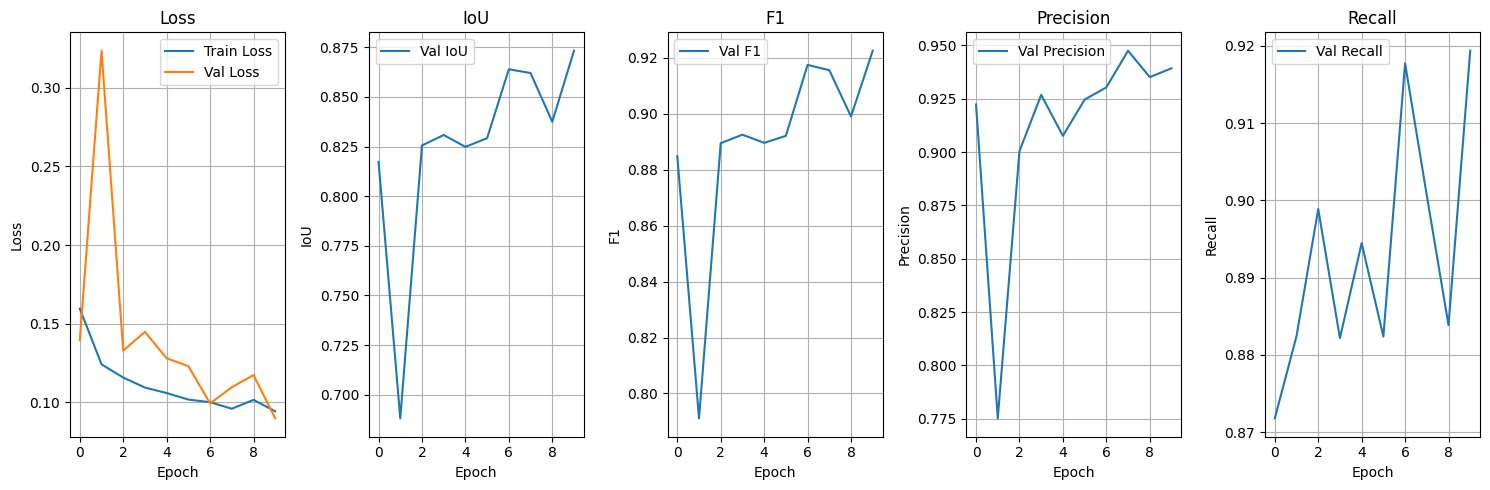


=== Performance Metrics Summary ===
IoU     - Best: 0.8733 | Final: 0.8733
F1      - Best: 0.9225 | Final: 0.9225
Precision - Best: 0.9475 | Final: 0.9393
Recall  - Best: 0.9194 | Final: 0.9194
Val Loss - Best: 0.0899 | Final: 0.0899



In [ ]:
# This code is adapted by Gemini (2025)

import geoai
import os
import matplotlib.pyplot as plt

model_output_dir = "building_model_output"
history_path = os.path.join(model_output_dir, "training_history.pth")

# Plotting the performance metrics
try:
    print(f"Attempting to load history from: {history_path}")
    geoai.plot_performance_metrics(
        history_path=history_path,
        figsize=(15, 5),
        verbose=True,
    )
    plt.show() # Ensure the plot is displayed if running in a notebook environment

except FileNotFoundError:
    print("\nERROR: Could not find 'training_history.pth'.")
    print("Please ensure your 'geoai.train_segmentation_model' ran to completion")
    print(f"and the file exists in the '{model_output_dir}' directory.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")